I've making this notebook while I am waiting for the data to be generated. 
If everything goes well, I will be able to use this notebook to analyze the data.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

In [7]:
# generate a likely dataset
data = pd.read_csv('example.csv')
print(data)

   n1  n2  init  train
0   1   1   0.5     15
1   1   4   0.8     33
2   2   2   0.6     25
3   2   4   0.7     30
4   3   3   0.7     30
5   4   1   0.8     33
6   4   2   0.9     38
7   4   4   2.0    100


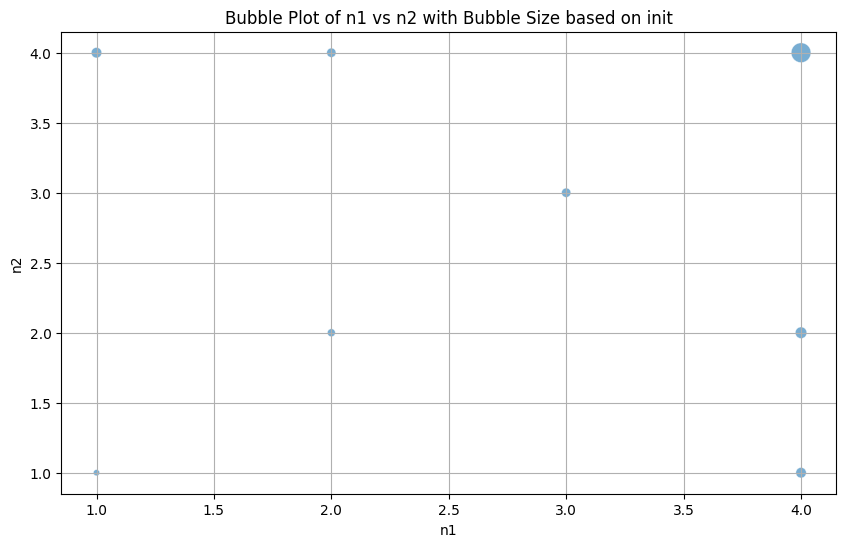

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='n1', y='n2', size='init', sizes=(20, 200), legend=False, alpha=0.6)
plt.xlabel('n1')
plt.ylabel('n2')
plt.title('Bubble Plot of n1 vs n2 with Bubble Size based on init')
plt.grid(True)
plt.show()

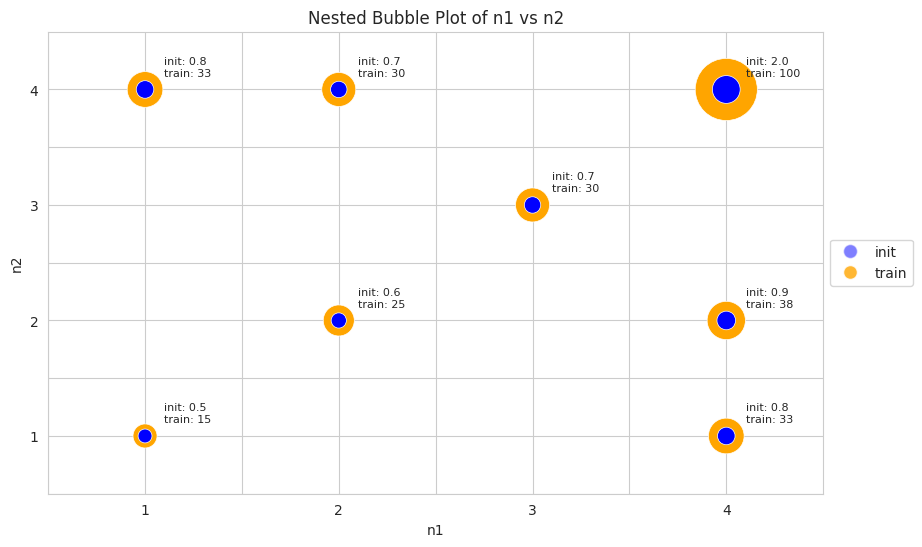

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the dataset
data = pd.read_csv('example.csv')

# Create the nested bubble plot
plt.figure(figsize=(10, 6))

# Plot the smaller nested bubbles for 'train'
plt.scatter(data['n1'], data['n2'], s=data['train']*20, alpha=1, label='train', edgecolors='w', linewidth=0.5, color='orange')

# Plot the larger bubbles for 'init'
plt.scatter(data['n1'], data['n2'], s=data['init']*200, alpha=1, label='init', edgecolors='w', linewidth=0.5, color='b')

plt.xlabel('n1')
plt.ylabel('n2')
plt.title('Nested Bubble Plot of n1 vs n2')

# Annotate each point with the values of 'init' and 'train' outside the bubbles
for i in range(len(data)):
    plt.text(data['n1'][i] + 0.1, data['n2'][i] + 0.1, f"init: {data['init'][i]}\ntrain: {data['train'][i]}",
             fontsize=8, ha='left', va='bottom')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='init',
                          markerfacecolor='b', markersize=10, alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', label='train',
                          markerfacecolor='orange', markersize=10, alpha=0.8)]

# Position the legend outside the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)

# Set custom ticks
plt.xticks(ticks=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['',1, '', 2, '', 3, '', 4])
plt.yticks(ticks=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['',1, '', 2, '', 3, '', 4])


plt.grid(True)
plt.show()
